# Introduction

Working with the FMA dataset which contains audio features and free music snippets on 100k+ tracks. This is in the interest of working towards my own MIR using deep learning to extract audio features from audio signals (probably using GTZAN).
The data comes from the [FMA dataset](https://github.com/mdeff/fma). Let's start by training a model to do feature extraction given an MFCC (derived from an audio signal). We can use the Echonest dataset which comes with audio features already extracted and use the FMA set with librosa to generate the MFCC.

## What Model?

Is a CNN really the best to use for a regression model? [Community](https://stats.stackexchange.com/questions/335836/cnn-architectures-for-regression) seems to say no, so what's the alternative? We could just change the scope of the problem to a classification one, where instead of extracting audio features like acousticness (on a scale of 0-1) we try to classify by genre. A CNN for genre classification is an interesting idea and maybe a good starting point, but for the time being I'll read more.

### Brainstorming
- A two-layer network implementation: the first being a genre classifier, the second being a regression on a set of features
- Adversarial learning technique to encode MFCC as a set of features as seen [here](http://cs229.stanford.edu/proj2017/final-reports/5218770.pdf)
- User implementation of the model: Given a playlist of liked tracks, train a simple logistic regression to classify new tracks as "Like" or "Dislike" using audio features

## Setup

We first need to import the necessary packages and load in the dataset. We'll use pandas--cause when have we not--and sklearn for the similarity metrics. 

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

filepath = "data/echonest.csv"

In this scenario we'll use both Euclidean distance and cosine similarity. I have my hesitations with using just cosine similarity here because we aren't dealing with documents. I need to understand the data a little better before I decide.

In the Pitchfork review recommender, we were using keywords from the album reviews to compare similarity. Longer reviews would be mapped to vectors with large word frequency values, due to those words appearing more often. But a shorter review with relatively the same differences in frequencies has lower frequency values leading to a greater Euclidean distance between the two despite being similar. Therefore, measuring the angle between the vectors is a better measure of similarity.

But in this case we have the features already provided for us, so I'll have to understand how the data is scaled and all before deciding on a metric for comparisons.

In [ ]:
df = pd.read_csv(filepath, index_col=0, header=[0, 1, 2])
print(df['echonest', 'audio_features'].head())

          acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
2             0.416675      0.675894  0.634476          0.010628  0.177647   
3             0.374408      0.528643  0.817461          0.001851  0.105880   
5             0.043567      0.745566  0.701470          0.000697  0.373143   
10            0.951670      0.658179  0.924525          0.965427  0.115474   
134           0.452217      0.513238  0.560410          0.019443  0.096567   

          speechiness    tempo   valence  
track_id                                  
2            0.159310  165.922  0.576661  
3            0.461818  126.957  0.269240  
5            0.124595  100.260  0.621661  
10           0.032985  111.562  0.963590  
134          0.525519  114.290  0.894072  


## Understanding the Dataset

My initial impression is that this dataset is [multi-tiered](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html), or a dataset made up of clearly defined subsets. There is the umbrella/master set (echonest), sub-categories of which are the different types of data features offered (i.e. audio_features, metadata, social_features, etc), these sub-categories in turn have sub-categories which are the columns of the dataframe. The columns are each a different feature within that type of data feature (i.e. acousticness and danceability under audio_features).

So there already exists a nice hierarchical structure to the data. We can leverage this to quickly test and compare the results of measuring similarity between tracks based on different features and types of features. One objective is to have a good understanding of the differences in measuring similarity using different sets of features.

Let's explore the data a little. Gotta figure out what all the types of features are and the features which comprise them. I'm mainly interested in the audio_features as a jumping off point to train the model. Also need some genre tags to serve as targets in the interest of training a genre classifier.

In [ ]:
audio_features_df = df['echonest','audio_features']
print(audio_features_df.columns.values)

['acousticness' 'danceability' 'energy' 'instrumentalness' 'liveness'
 'speechiness' 'tempo' 'valence']


# Genre Classification

As a way of exploring the dataset through deep learning, and an excuse to use CNN's for music analysis, let's build a genre classifier in TensorFlow which implements a CNN. We'll use librosa to read in the MFCC's as numpy arrays, then use the genres provided in the FMA dataset to build our training/testing set. Split 70/30 and we can start training, possibly using the Colab GPU runtime environment.

The data is going to come from the Full Music Archive which offers free, legal music for download with CC licensing. I can start with the small subset which is roughly 8gb and GTZAN-like. As the preeminent dataset for genre classification it seems proper to start with GTZAN. 

## Setup FMA data repository

Clone the FMA git repository and download the fma_small and fma_metadata for genre recognition. Genre tags and MFCC features are in fma_metadata. Actual mp3 files for song snippets are in fma_small 

Let's download and load in the fma_metadata and fma_small subset of the full FMA dataset. Then we can do some exploratory analytics to view some of the tracks as MFCC's (using librosa) and get the genre labels.

__Note__: path to data folder is: ./fma

### Clone FMA repository

In [1]:
!ls
!pwd

sample_data
/content


In [2]:
!git clone https://github.com/mdeff/fma.git
%cd fma

Cloning into 'fma'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 779 (delta 110), reused 194 (delta 96), pack-reused 561
Receiving objects: 100% (779/779), 4.11 MiB | 3.63 MiB/s, done.
Resolving deltas: 100% (495/495), done.
/content/fma


### Install requirements using pip

In [13]:
%cd fma

[Errno 2] No such file or directory: 'fma'
/content/fma


In [14]:
!pwd
!pip install -q --upgrade pip setuptools wheel
!pip install -q numpy  # workaround resampy's bogus setup.py
!pip install -q -r requirements.txt

/content/fma


### Install fma_small and fma_metadata and unzip

In [5]:
%cd data
!curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip
!curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

/content/fma/data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7323M  100 7323M    0     0  10.6M      0  0:11:26  0:11:26 --:--:-- 10.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341M  100  341M    0     0  9515k      0  0:00:36  0:00:36 --:--:-- 11.1M


In [6]:
!echo "f0df49ffe5f2a6008d7dc83c6915b31835dfe733  fma_metadata.zip" | sha1sum -c -
!echo "ade154f733639d52e35e32f5593efe5be76c6d70  fma_small.zip"    | sha1sum -c -
!unzip fma_metadata.zip
!unzip -q fma_small.zip
%cd ..

fma_metadata.zip: OK
fma_small.zip: OK
Archive:  fma_metadata.zip
 bunzipping: fma_metadata/README.txt  
 bunzipping: fma_metadata/checksums  
 bunzipping: fma_metadata/not_found.pickle  
 bunzipping: fma_metadata/raw_genres.csv  
 bunzipping: fma_metadata/raw_albums.csv  
 bunzipping: fma_metadata/raw_artists.csv  
 bunzipping: fma_metadata/raw_tracks.csv  
 bunzipping: fma_metadata/tracks.csv  
 bunzipping: fma_metadata/genres.csv  
 bunzipping: fma_metadata/raw_echonest.csv  
 bunzipping: fma_metadata/echonest.csv  
 bunzipping: fma_metadata/features.csv  
/content/fma


### Create some util functions

Create the `load()` and `get_audio_path()` util functions from the fma repo. They can't be loaded into a Colab environment from utils.py due to some syntax error--probably because of a Python version error.

In [15]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except ValueError:
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

## Explore data and build a simple genre classifier using an SVM

In [16]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import ast

AUDIO_DIR = 'data/fma_small'

In [17]:
genres = load('data/fma_metadata/genres.csv')
features = load('data/fma_metadata/features.csv')
tracks = load('data/fma_metadata/tracks.csv')
echonest = load('data/fma_metadata/echonest.csv')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [19]:
# Be sure training data is shuffled
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%


Awesome! We've got a pretty shitty genre classifier using an SVM. This can serve as our baseline for now. Credit goes to [the FMA usage guide](https://nbviewer.jupyter.org/github/mdeff/fma/blob/outputs/usage.ipynb).

## MFCC visualizations using librosa

Below we'll use librosa to load in an audio file that's playable from the notebook.

In [9]:
filename = get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: data/fma_small/000/000002.mp3
Duration: 29.00s, 1321967 samples


Now we can use librosa to display the above audio file as a spectrogram.

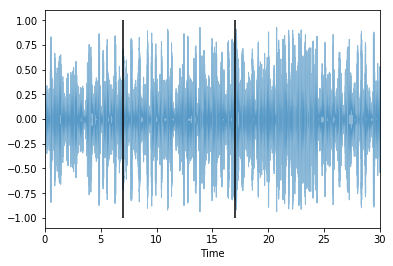

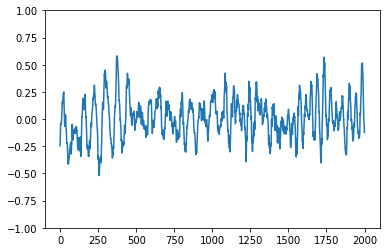

In [10]:
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

Now that I have the waveform of the audio file loaded in using librosa, I can leverage the Fourier Transform to extract its constituent frequencies. Of course librosa offers a FFT function of its own (fast fourier trasnforms using, I assume, a fourier series to the n'th degree). But I think it'd be fun to try and apply the fourier transform on my own at least for a portion of the 30-sec clip and compare the results to librosa's.

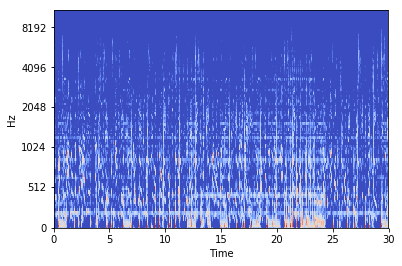

In [11]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
# mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
mel = librosa.feature.melspectrogram(x, sr=sr,n_fft=2048, hop_length=512)
# mel = librosa.power_to_db(mel, ref=np.max)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');
librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

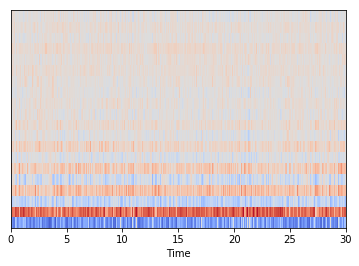

In [12]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

## Building the Training and Testing Sets

We need to generate images for each track and then attach that to the target prediction value which is the genre of that track. So our final dataframe before the train-test split should have images in one column and the genre in another. The images column can be a serialized representation or the name of a filepath.

I'm going to save the new dataset via "pickling" so that I can quickly load it for training/testing.


## An Unsupervised Implementation


While we can start by training a CNN in a supervised manner (by providing genres from the EchoNest dataset as targets) it may be interesting to look into an unsupervised approach as well. The machine may come up with new and novel descriptors to group songs by, and it'll be interesting to compare and contrast those with human defined labels. It was mentioned in the primer on Music Rec Systems that there is a semantic gap to bridge between machine generated labels and human annotations.